source: https://www.kaggle.com/tomras/cnn-classifier-using-keras

In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.utils.vis_utils import plot_model
import pydot

Using TensorFlow backend.


Note: This notebook assumes keras-gpu is installed instead of the regular keras

Note: You'll need to downgrade to python 3.7 to install keras-gpu

Check for GPUs

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7119616542357778867
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6610781471
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10205106067612291229
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


load data

In [3]:
f = open(r'./data/shipsnet.json')
dataset = json.load(f)
f.close()
data = np.array(dataset['data']).astype('uint8')
labels = np.array(dataset['labels']).astype('uint8')

normalize and split data

In [13]:
x = data / 255.
x = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
print(x.shape)
trainx=x[:3600]
y = to_categorical(labels, num_classes=2)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

(4000, 80, 80, 3)
(4000, 2)


define a basic CNN

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

train the model

In [15]:
history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_split=0.2)
score = model.evaluate(X_test, y_test) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Train on 2720 samples, validate on 680 samples
Epoch 1/40
2720/2720 [==============================] - 2s 785us/step - loss: 0.3508 - accuracy: 0.8485 - val_loss: 0.1663 - val_accuracy: 0.9324s: 0.4681  - ETA: 0s - loss: 0.3877 - accuracy:  - ETA: 0s - loss: 0.3687 - accuracy: 
Epoch 2/40
2720/2720 [==============================] - 2s 721us/step - loss: 0.1849 - accuracy: 0.9217 - val_loss: 0.1091 - val_accuracy: 0.9529
Epoch 3/40
2720/2720 [==============================] - 2s 720us/step - loss: 0.1856 - accuracy: 0.9228 - val_loss: 0.1000 - val_accuracy: 0.9618
Epoch 4/40
2720/2720 [==============================] - 2s 718us/step - loss: 0.0871 - accuracy: 0.9680 - val_loss: 0.1027 - val_accuracy: 0.96031s - loss: 0.0888 - accuracy - ETA: 1s - loss: 0.1068 - accuracy - ETA: 0s - loss: 0.1010 - accuracy: 0. - ETA: 0s - loss: 0.0960 - ac - ETA: 0s - loss: 0.0882 - accuracy
Epoch 5/40
2720/2720 [==============================] - 2s 715us/step - loss: 0.0652 - accuracy: 0.9746 - val_los

In [7]:
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)       

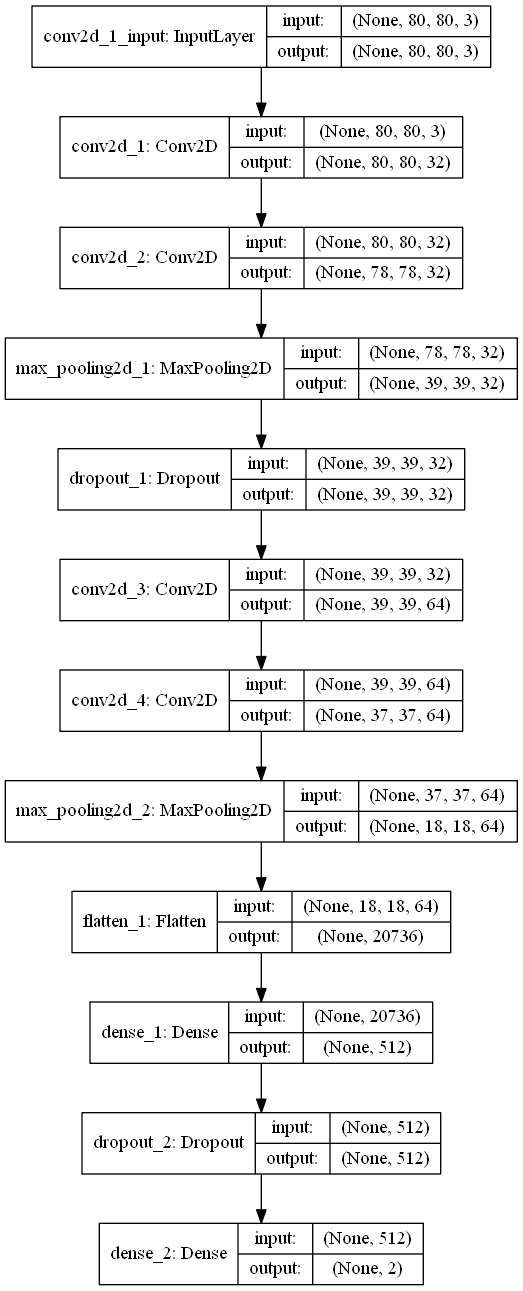

In [8]:

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

create the model in a way that can be passed to a scikit wrapper for cross-validation

In [9]:
def create():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])
    return model

run cross-validation

In [10]:
cnn = KerasClassifier(build_fn=create, epochs=40, batch_size=32,validation_split=.2)
scores=cross_val_score(cnn, X_train, y_train, cv=3)
print(np.mean(scores))

Train on 1812 samples, validate on 454 samples
Epoch 1/40
1812/1812 [==============================] - 2s 1ms/step - loss: 0.4209 - accuracy: 0.8173 - val_loss: 0.2163 - val_accuracy: 0.9163
Epoch 2/40
1812/1812 [==============================] - 1s 753us/step - loss: 0.2471 - accuracy: 0.8979 - val_loss: 0.1746 - val_accuracy: 0.9361
Epoch 3/40
1812/1812 [==============================] - 1s 746us/step - loss: 0.1962 - accuracy: 0.9227 - val_loss: 0.1584 - val_accuracy: 0.9449
Epoch 4/40
1812/1812 [==============================] - 1s 752us/step - loss: 0.1574 - accuracy: 0.9404 - val_loss: 0.0987 - val_accuracy: 0.9670
Epoch 5/40
1812/1812 [==============================] - 1s 738us/step - loss: 0.1081 - accuracy: 0.9570 - val_loss: 0.0811 - val_accuracy: 0.9692
Epoch 6/40
1812/1812 [==============================] - 1s 741us/step - loss: 0.0742 - accuracy: 0.9757 - val_loss: 0.0736 - val_accuracy: 0.9714
Epoch 7/40
1812/1812 [==============================] - 1s 741us/step - loss: 0

Epoch 14/40
1813/1813 [==============================] - 1s 744us/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.0603 - val_accuracy: 0.9846
Epoch 15/40
1813/1813 [==============================] - 1s 736us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9890
Epoch 16/40
1813/1813 [==============================] - 1s 742us/step - loss: 9.9794e-04 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9846oss: 0.0012 - accu
Epoch 17/40
1813/1813 [==============================] - 1s 741us/step - loss: 5.7885e-04 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9846
Epoch 18/40
1813/1813 [==============================] - 1s 767us/step - loss: 4.8905e-04 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9868
Epoch 19/40
1813/1813 [==============================] - 1s 749us/step - loss: 2.1240e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9868
Epoch 20/40
1813/1813 [==============================] - 1s 765us/step - loss: 0.003

try and fail to create a roc curve for this network

In [11]:

#from sklearn.metrics import roc_curve
#y_pred_keras = keras_model.predict(X_test)
#print(y_pred_keras)
#y_pred_keras=np.max(y_pred_keras,axis=1)
#print(y_test.shape)
#print(np.max(y_test,axis=1))
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.max(y_test,axis=1), y_pred_keras)
#from sklearn.metrics import auc
#auc_keras = auc(fpr_keras, tpr_keras)

In [12]:

#plt.figure(1)
#plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
#plt.title('ROC curve')
#plt.legend(loc='best')
#plt.show()